Relative Measurements:
----------------------


When calibrating a model to data, it's common to only have access to relative measurements.  For example, instead of having absolute protein levels in units of uM, your only measure of protein abundance is intensity of bands in
[western blots](http://en.wikipedia.org/wiki/Western_blot).  Other common examples are relative abundance measurements from mass spectrometry, counts from photodetectors, or RNA abundance from RNAseq, etc...

For example, here is what a western block (**column A**) looks like with its relative quantification (**column B**):

![img](https://openi.nlm.nih.gov/imgs/512/33/3815147/PMC3815147_pone.0079073.g004.png?keywords=sd)

(taken from: https://openi.nlm.nih.gov/detailedresult.php?img=PMC3815147_pone.0079073.g004&req=4).

Calibrating Models with Data in Arbitrary Units:
------------------------------------------------


How can we use this data (in arbitrary units) to calibrate a model where the quantities have specific physical meaning?  In an ideal case, we can do additional experiments and build calibration curves to calculate the conversion factor between protein levels and the intensity of bands in western blots, but this is not always possible.  Alternatively, we can make our models completely [dimensionless](https://en.wikipedia.org/wiki/Nondimensionalization) by rescaling all quantities in our model by appropriately chosen constants.  

A third option is to use scaling factors.  To do this, we assume that in the range in which we are interested, the amount of signal measured by our instrument is linearly proportional to the amount of protein/RNA.  In practice, the relationship usually follows a saturation curve, which can be described by something like a [Hill function](https://en.wikipedia.org/wiki/Hill_equation_%28biochemistry%29).  The Hill Function is probably my 2nd favorite case of a mathematical formula being invented by someone with the perfect name - the undisputed first is still the [Poynting vector](https://en.wikipedia.org/wiki/Poynting_vector) which does exactly what the name suggests.



Linearizing Saturation Curves:
------------------------------

Fortunately, a saturation curve with a large exponent can be approximated by a linear fit quite accurately, as long as we are careful to make sure our measurements are done in the correct range.

In [1]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline


def hill(L, Km, Vmax, n):
    """
    Standard Hill function"""
    numerator = Vmax*(L**n)
    denominator = Km**n + L**n
    
    return numerator/denominator

# To calculate the gradient of the Hill function (with respect to L) we use autograd.
hill_grad = grad(hill)

In [2]:
L = np.linspace(0, 1.5, 100)
Km = 0.5
Vmax = 1
n = 5

v = hill(L, Km, Vmax, n)

# Evaluate the gradient at 0.5 wrt L
dv_dl = hill_grad(0.5, Km, Vmax, n)

# Approximate the Hill function as a linear equation using a 1st order Taylor series:
v_approx = hill(0.5, Km, Vmax, n) + (L-0.5) * dv_dl

(0, 1)

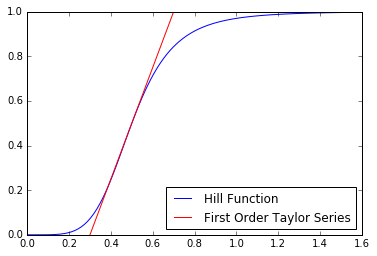

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(L, v, label='Hill Function')
ax.plot(L, v_approx, 'r', label='First Order Taylor Series')

ax.legend(loc='best')
ax.set_ylim(0, 1)

Example Problem: Actin Polymerization
-------------------------------------

Let's say we want to model the [polymerization of actin](https://en.wikipedia.org/wiki/Actin#Assembly_dynamics) from barbed ends *in-vitro*.  This is described by a very simple differential equation:

$\frac{dFa(t)}{dt} = k_{on}*N_b*Ga(t) - k_{off}*N_b$

where $Fa$ is the amount of filamentous (polymerized) actin, $Ga$ is the amount of globular (soluble) actin, $N_b$ is the amount of barbed ends (filaments from which actin can grow) and $k_{on} , k_{off}$ are the 1st and 0th order binding and unbinding parameters.  If we are working in a system with excess ATP, and where the total amount of actin is conserved ($At = Fa + Ga$), this has an exact analytical solution, which we could solve using integrating factors - or, since we are lazy, just using SymPy.

In [4]:
from sympy import *
init_printing()

In [5]:
At, Nb, k_on, k_off, t = symbols('At Nb k_on k_off t', positive=True)
Fa = Function('Fa')(t)
Ga = At - Fa

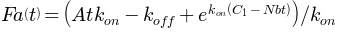

In [6]:
eq = Eq(k_on*Ga*Nb - k_off*Nb, diff(Fa, t))
sol = dsolve(eq)
sol.simplify()

This solution has an integration constant.  Assume that Fa(0) = 0 (meaning, at time zero, all actin is in soluble form)

In [7]:
#Solve for initial condition of 0 F-Actin at t=0
initial_cond = solve(sol.rhs.subs(t, 0), 'C1')[0]
sol = sol.rhs.subs('C1', initial_cond)

fact_timecourse = lambdify([At, k_off, k_on, Nb, t],
                           sol.simplify(), modules='numpy')

# We take advantage of SymPy again to obtain the gradient
# of the function wrt the number of barbed ends
fact_grad = lambdify([At, k_off, k_on, Nb, t],
                     diff(sol, Nb).simplify(), modules='numpy')

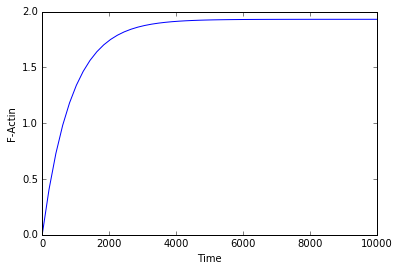

In [8]:
timesteps = np.linspace(0.01, 10000)
simulation = fact_timecourse(2, 0.8, 11.6, 0.0001, timesteps).ravel()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(timesteps, simulation)
ax.set_xlabel('Time')
ax.set_ylabel('F-Actin')

What if we didn't actually know the number of barbed ends in solution, and wanted to estimate it on the basis of F-Actin time course data?  That's very easy using SciPy and SymPy!

This is just a simple least squares minimization problem:

$\underset{x}{\arg\min} \sum_i(F(x)_i - y_i)^2$

Where $F(x)_i$ is our simulation of actin dynamics, $x$ is our unknown parameter (in this case, the number of barbed ends - we presume we know everything else) and $y_i$ is the experimental data.

In [9]:
def fact_residuals(p, data):
    '''
    Returns the residuals between the simulation calculated
    with nb == p[0] and the original simulation with the known
    value of nb
    '''
    nb = p[0]
    new_sim = fact_timecourse(2, 0.8, 11.6, nb, timesteps).ravel()
    residuals = new_sim - data
    return residuals


def fact_jac(p, data):
    '''
    Returns the jacobian: The gradient at every timestep
    with respect to nb.  Since we are only optimizing a
    single parameter, this has an extra axis.'''
    nb = p[0]
    return fact_grad(2, 0.8, 11.6, nb, timesteps).reshape(-1, 1)
    
from scipy.optimize import leastsq

out = leastsq(fact_residuals, 0.2, args=(simulation,), full_output=True,
              col_deriv=True, Dfun=fact_jac)

out[0]

array([ 0.0001])

Working with arbitrary units:
------------------------------


But, suppose that instead of having $y_i$ in units of concentration, we measure $y_i$ using a fluorescence assay and our units are arbitrary.  In practice, actin polymerization is almost always measured using [pyrene](https://en.wikipedia.org/wiki/Pyrene) actin, a specially labeled form of actin that becomes fluorescent when it polymerizes.

Now, we can no longer directly minimize the difference between our simulation and the experimental data, since our simulation is in units of concentration, and our measurents are in arbitrary units.  One option is to explicitly add a parameter to our model.  We can simply define a new function, $G(x)$:

$G(x) = x[0] * f(x[1:])$

which takes an extra parameter, and scales the simulation.  This however adds a parameter to the model, and, in my experience, makes parameter much slower.

Implicit Scale Factors:
-----------------------

An alternative way is to write out the minimization like so (we are assuming [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity) to simplify the expression and ignore the variance of each individual point):

$\underset{x}{\arg\min}  \bigg| \sum_i (\beta F(x)_i - y_i)  \bigg|_2$

At this point - we notice that, for a given set of parameters $x$, our loss function implicitly defines an optimal scaling factor $\beta$ - it's the scaling factor that minimizes the residuals, given a simulation $F(x)$ and data $y$.

To find the optimal scale factor, we derive our loss function with respect to $\beta$

$$
\frac{d} {d \beta} \bigg| \sum_i (\beta F(x)_i - y_i)  \bigg|_2 = 0 \\
$$

 and solve (the best reference I've found for this is [Ryan Gutenkust's PhD thesis](http://www.lassp.cornell.edu/sethna/pubPDF/GutenkunstPhD.pdf) and the corresponding implementation in [SloppyCell](https://sourceforge.net/p/sloppycell/git/ci/master/tree/Model_mod.py#l568):
 
$$
\beta = \frac{\sum_i F(x)_i y_i }{\sum_i F(x)_i^2 } \\
$$

Updating the Jacobian:
----------------------

However, now when we calculate the Jacobian, we also have to consider the effect that varying the parameter will have on the scaling factor:

$$
\frac{d}{dx} (\beta(x) F(x)) = \frac{d\beta(x)}{dx}F(x) + \frac{dF(x)}{dx}\beta(x)
$$

$ \frac{dF(x)}{dx}$ is the old Jacobian.  Now we need to calculate $\frac{d\beta(x)}{dx}$.  To obtain that, we derive the equation for $\beta$ with respect to $x$.

$$
\frac{d\beta}{dx} = \frac{d}{dx}  \frac{ \sum_i \frac{dF(x)_i}{dx} y_i}{ \sum_i F(x)_i^2}
$$

Let's write a quick and dirty implementation of the different functions.

In [10]:
def calculate_sf(sim, data):
    """
    Calculates the optimal scale factor (B) between
    simulated and experimental data.
    """
    sim_dot_exp = np.sum(sim * data)
    sim_dot_sim = np.sum(sim * sim)
    return sim_dot_exp / sim_dot_sim
    
def calculate_sf_grad(sim, data, sim_jac):
    """
    Calculates the gradient of the scale factor 
    (dB/dx) with respect to the parameters being
    optimized.
    """
    sim_dot_exp = np.sum(sim * data)
    sim_dot_sim = np.sum(sim * sim)
    jac_dot_exp = np.sum(sim_jac.T * data, axis=1)
    jac_dot_sim = np.sum(sim_jac.T * sim, axis=1)
    
    sf_grad = (jac_dot_exp / sim_dot_sim - 2 *  \
               (sim_dot_exp * jac_dot_sim) / (sim_dot_sim)**2)

    return sf_grad

def scaled_fact_residuals(p, data):
    """
    Calculates the residuals between simulated data and
    experimental data after scaling the simulations using
    the scale factor.
    """
    
    nb = p[0]
    new_sim = fact_timecourse(2, 0.8, 11.6, nb, timesteps).ravel()
    beta = calculate_sf(new_sim, data)
    residuals = beta*new_sim - data
    
    return residuals

def scaled_fact_jac(p, data):
    """
    Calculates the jacobian of the simulation with respect to the parameter
    being optimized including the contribution of the scale factor:
    
    (d/dx B(x)F(x) = dB(x)/dx*F(x) + dF(x)/dx*B(x))
    """
    nb = p[0]
    
    # We could write this using caching to avoid recalculating f(x) and B(x)
    # In case we have already computed them with a given p
    new_sim = fact_timecourse(2, 0.8, 11.6, nb, timesteps).ravel()
    beta = calculate_sf(new_sim, data)
    
    jac = fact_grad(2, 0.8, 11.6, nb, timesteps).reshape(-1, 1)
    beta_grad = calculate_sf_grad(new_sim, data, jac)
    
    return beta_grad*new_sim + (jac*beta).T


Let's test to see if the scale factor calculation works as we expect:

In [11]:
nb = 0.0001

new_sim = fact_timecourse(2, 0.8, 11.6, nb, timesteps).ravel()

scaled_measures = simulation*1.7
sf = calculate_sf(new_sim, scaled_measures)

print sf

1.7


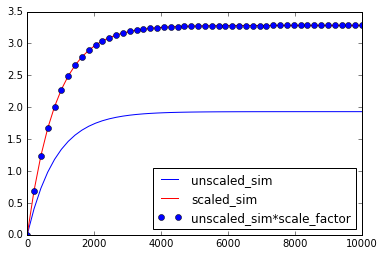

In [12]:
plt.plot(timesteps, new_sim, label='unscaled_sim')
plt.plot(timesteps, scaled_measures, 'r-', label='scaled_sim')
plt.plot(timesteps, new_sim*sf, 'bo',
         label='unscaled_sim*scale_factor')
plt.legend(loc='best')

Now, let's check to see if the optimization procedure works:

In [13]:
init_guess = [0.1]
out = leastsq(scaled_fact_residuals, init_guess,
              args=(scaled_measures,),
              full_output=True, col_deriv=True,
              Dfun=scaled_fact_jac)
out[0]

array([ 0.0001])

It does!  We recover the correct number of barbed ends.  Note that this result applies for more complex minimization functions where you have multiple scale factors, or where $F(x)$ is only available implicitly - such as when numerically integrating a set of differential equations.  In practice, for any large optimization problem, calculating the scale factors will almost never be a significant slowdown: what will end up dominating the run time are either computing $F(x)$ and it's Jacobian $\frac{dF(x)}{dx}$ or inverting the pseudo-Hessian inside the Levemberg-Marquardt algorithm.


Numerical Considerations:
---------------------------

However, one problem (extensively discussed in Ryan's excellent PhD thesis) is that the presence of scale factors can cause numerical convergence issues - by pushing the parameters into regimes where numerical integration becomes very slow.  To solve this, Ryan proposes some relatively weak Bayesian priors on the scale factors and the parameters - which then allows us to use the LM algorithm to find the [MAP](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) solution.  Priors then play a dual role: they allow us to include some prior information about the likely range of parameters (although this is very minor: parameters in systems biology models are inherently [sloppy](http://www.lassp.cornell.edu/sethna/Sloppy/WhatAreSloppyModels.html)) and they make the estimation procedure more stable.